In [ ]:
import pandas as pd
import numpy as np
import re
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%pip install camel-tools
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.21.0-py3-none-any.whl (4.7 MB)
  Using cached tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.10.1
    Uninstalling transformers-4.10.1:
      Successfully uninstalled transformers-4.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ktrain 0.31.6 requires transformers==4.10.1, but you have transformers 4.21.0 which is incompatible.


In [ ]:
# clean the data from nonsense words, to help speed up the training process
import os
import re
import nltk
import numpy as np
import pandas as pd
from nltk import tokenize
nltk.download('stopwords')
#!pip install emoji
import spacy
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import string
from sklearn.utils import shuffle

from nltk.tokenize import sent_tokenize, word_tokenize
import string
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/baaz/Untitled folder/fulldf.csv')

In [ ]:
data

,Text,Label
0,ارقام فائزين الاستاذ محمد شاركوا معه فقط لايك ...,Spam
1,سحب مبلغ ارقام كااش تابع لايك للمثبته بحسابها ...,Spam
2,شروط المسابقه ريتويت لايك منش هشتاق مسابقات اف...,Spam
3,ضيفني لايك رتويت سوي فولو الرتويت اضمن اكثر ار...,Spam
4,الله اي لايك,Normal
...,...,...
36185,اخذت يدي وبدات باناملها الصغيرة ترسم خطوط قدري...,Normal
36186,صاحب مقولة خرب نومه خرب يومه اكثر انسان حكيم و...,Normal
36187,جمال ورقي اختيار الكلمات الصينيون ارسلوا شحنات...,Normal
36188,عيت صابر,Normal


In [ ]:
from imblearn.datasets import make_imbalance
X, y = make_imbalance(
    data['Text'].values.reshape(-1, 1),
    data['Label'],
    sampling_strategy={'Normal': 7456, 'Offensive': 5123},
    random_state= 42)

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))

def modify_arabic_post(text):
  text = re.sub('_+', ' ', text)
    ## To find arabic Tashkeel
  arabic_diacritics = re.compile("""
                              ّ    | # Tashdid
                              َ    | # Fatha
                              ً    | # Tanwin Fath
                              ُ    | # Damma
                              ٌ    | # Tanwin Damm
                              ِ    | # Kasra
                              ٍ    | # Tanwin Kasr
                              ْ    | # Sukun
                              ـ     # Tatwil/Kashida
                          """, re.VERBOSE)
  # Remove Tashkeel
  input_str = re.sub(arabic_diacritics, '', text)
  #remove url
  input_str=re.sub('(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])','',input_str)
  # Remove '@name'
  input_str = re.sub(r'(@.*?)[\s]', ' ', input_str)
  # Replace digits
  input_str = re.sub('[0-9]+', 'ارقام', input_str)
  s='٠١٢٣٤٥٦٧٨٩'
  input_str = re.sub('['+s+']+', 'ارقام', input_str)
  # Remove trailing whitespace
  input_str = re.sub(r'\s+', ' ', input_str).strip()
  # Remove punctuation
  input_str = re.sub(r'[^\w\s]',' ',input_str)
  #remove email
  input_str = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", "",  input_str, flags=re.MULTILINE)
  regex = re.compile(r'[\u0621-\u064A]+')
  input_str = " ".join(regex.findall(input_str))
  # Remove underscore
  input_str = re.sub('_+' , ' ', input_str)
  # Remove newLine
  input_str = re.sub(r'\n+', ' ', input_str)
  # Normalization
  input_str = re.sub("[إأآا]", "ا", input_str)
  input_str = re.sub("گ", "ك", input_str)
  # Remove duplicate ch more than 2
  pattern=re.compile(r"(.)\1{1,}",re.DOTALL)
  input_str = pattern.sub(r"\1\1",input_str)
  # Delete repeated words
  input_str = re.sub(r'\b(\w+)( \1\b)+', r'\1', input_str)
  # Delete non arabic characters
  regex = re.compile('[^0-9\u0621-\u064A\u0660-\u0669 ]')
  input_str = regex.sub('', input_str)
  # Delete consective spaces and spaces in begining and end
  input_str = input_str.strip()
  input_str = re.sub('\s+',' ',input_str)
  input_str = re.sub(' +', ' ', input_str)
  #stop word
  filtered_sentence = [w for w in input_str.split() if not w in arb_stopwords]
  input_str= ' '.join(filtered_sentence)
  #punctuation
  translator = str.maketrans('', '', punctuations_list)
  input_str= input_str.translate(translator)
  return input_str

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data['Text']=data['Text'].apply(modify_arabic_post)

In [ ]:
data['Text']

0        ارقام فائزين الاستاذ محمد شاركوا معه فقط لايك ...
1        سحب مبلغ ارقام كااش تابع لايك للمثبته بحسابها ...
2        شروط المسابقه ريتويت لايك منش هشتاق مسابقات اف...
3        ضيفني لايك رتويت سوي فولو الرتويت اضمن اكثر ار...
4                                             الله اي لايك
                               ...                        
36185    اخذت يدي وبدات باناملها الصغيرة ترسم خطوط قدري...
36186    صاحب مقولة خرب نومه خرب يومه اكثر انسان حكيم و...
36187    جمال ورقي اختيار الكلمات الصينيون ارسلوا شحنات...
36188                                             عيت صابر
36189                                 ينعل ابو الفيس البوك
Name: Text, Length: 36190, dtype: object

In [ ]:
sentences_lengths = np.array(list(map(len, data['Text'])))
np.max(sentences_lengths)

12275

In [ ]:
MAX_LEN = int(np.ceil(np.percentile(sentences_lengths, 90)))
MAX_LEN

162

In [ ]:
class_names = data['Label'].unique()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['Text'],data['Label'],stratify=data['Label'], test_size=0.2, random_state=42)

X_train = X_train.tolist()
y_train = y_train.to_numpy()
X_test = X_test.tolist()
y_test = y_test.to_numpy()

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.10.1-py3-none-any.whl (2.8 MB)
  Using cached tokenizers-0.10.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled tokenizers-0.12.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.21.0
    Uninstalling transformers-4.21.0:
      Successfully uninstalled transformers-4.21.0


In [ ]:
import ktrain
from ktrain import text

In [ ]:
MODEL_NAME = 'aubmindlab/bert-base-arabertv02'

In [ ]:
transfomer = text.Transformer(MODEL_NAME,class_names= class_names, maxlen=90)

In [ ]:
train = transfomer.preprocess_train(X_train, y_train)
validation = transfomer.preprocess_test(X_test, y_test)
model = transfomer.get_classifier()

preprocessing train...
language: ar
train sequence lengths:
	mean : 14
	95percentile : 37
	99percentile : 70


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:738: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  "class_names argument was ignored, as they were extracted from string labels in dataset"


Is Multi-Label? False
preprocessing test...
language: ar
test sequence lengths:
	mean : 14
	95percentile : 37
	99percentile : 69


In [ ]:
train

In [ ]:
learner = ktrain.get_learner(model, train_data=train, val_data=validation)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
904/904 [==============================] - 563s 586ms/step - loss: 0.6929 - accuracy: 0.6863
Epoch 2/3
904/904 [==============================] - 533s 590ms/step - loss: 0.9672 - accuracy: 0.6709
Epoch 3/3
904/904 [==============================] - 17s 19ms/step - loss: 3.3402 - accuracy: 0.5151


done.
Visually inspect loss plot and select learning rate associated with falling loss


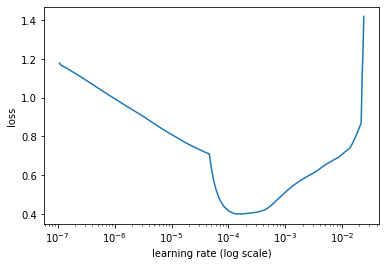

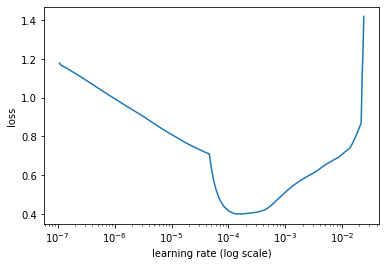

In [ ]:
# It may need long time but ensures healthy training


learner.lr_find(show_plot=True, max_epochs=3)

# After the learning rate find process plot the curve of leaning rate - loss to select best learning rate
learner.lr_plot()

In [ ]:
learner.autofit(1e-5, 3)
learner.validate(class_names=transfomer.get_classes())



begin training using triangular learning rate policy with max lr of 1e-05...
Epoch 1/3
905/905 [==============================] - 600s 641ms/step - loss: 0.4763 - accuracy: 0.7992 - val_loss: 0.3460 - val_accuracy: 0.8518
Epoch 2/3
905/905 [==============================] - 581s 636ms/step - loss: 0.3133 - accuracy: 0.8733 - val_loss: 0.3223 - val_accuracy: 0.8689
Epoch 3/3
905/905 [==============================] - 581s 637ms/step - loss: 0.2646 - accuracy: 0.8945 - val_loss: 0.3078 - val_accuracy: 0.8768
              precision    recall  f1-score   support

      Normal       0.91      0.90      0.91      4685
   Offensive       0.81      0.82      0.82      2071
        Spam       0.80      0.93      0.86       482

    accuracy                           0.88      7238
   macro avg       0.84      0.88      0.86      7238
weighted avg       0.88      0.88      0.88      7238



array([[4206,  380,   99],
       [ 368, 1692,   11],
       [  29,    5,  448]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, transfomer)

